In [1]:
import os
import random
import shutil

from shutil import copyfile

In [2]:

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = VALIDATION_DIR

In [3]:

# remove directory

for i in ['train', 'test']:
    shutil.rmtree(f'./{i}')

In [4]:
# create directory

label = ['a', 'b']

# simpler code
for i in ['train', 'test']:
    os.makedirs(f'./{i}')
    for j in label:
        os.makedirs(f'./{i}/{j}')

In [5]:
split_size = .9

for i in label:
    # again, simpler code
    split_data(f'./dataset-features/{i}', f'./train/{i}', f'./test/{i}', split_size)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = './train/',
                                                      batch_size = 32,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = './test/',
                                                                batch_size = 8,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))

  return train_generator, validation_generator

In [7]:
train_generator, validation_generator = train_val_generators('./train/', './test/')

Found 1334 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [10]:
from keras.callbacks import Callback

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.9 and logs.get('accuracy') > 0.9:
            self.model.stop_training = True

In [11]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=1000,
                    batch_size=50,
                    validation_data=validation_generator,
                    validation_steps=2,
                    callbacks = MyCallback())

Epoch 1/1000
42/42 [==============================] - 17s 318ms/step - loss: 0.7626 - accuracy: 0.5652 - val_loss: 0.6692 - val_accuracy: 0.6875
Epoch 2/1000
42/42 [==============================] - 7s 166ms/step - loss: 0.7112 - accuracy: 0.5750 - val_loss: 0.7553 - val_accuracy: 0.3750
Epoch 3/1000
42/42 [==============================] - 6s 153ms/step - loss: 0.6986 - accuracy: 0.5615 - val_loss: 0.6733 - val_accuracy: 0.5625
Epoch 4/1000
42/42 [==============================] - 7s 155ms/step - loss: 0.6857 - accuracy: 0.5765 - val_loss: 0.6763 - val_accuracy: 0.6875
Epoch 5/1000
42/42 [==============================] - 7s 155ms/step - loss: 0.6760 - accuracy: 0.5765 - val_loss: 0.5985 - val_accuracy: 0.6250
Epoch 6/1000
42/42 [==============================] - 6s 152ms/step - loss: 0.6741 - accuracy: 0.6072 - val_loss: 0.6246 - val_accuracy: 0.8125
Epoch 7/1000
42/42 [==============================] - 7s 155ms/step - loss: 0.6595 - accuracy: 0.5952 - val_loss: 0.6345 - val_accuracy

In [18]:
model.save('object-features.h5')

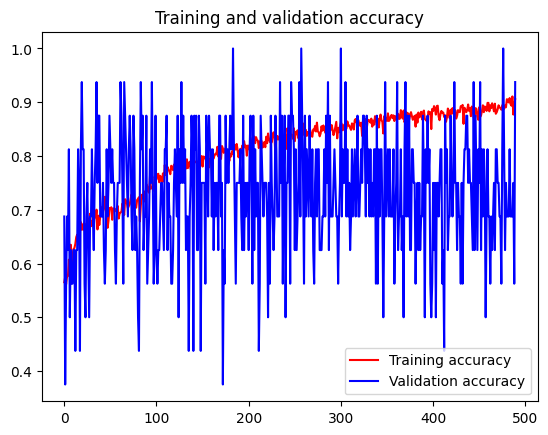

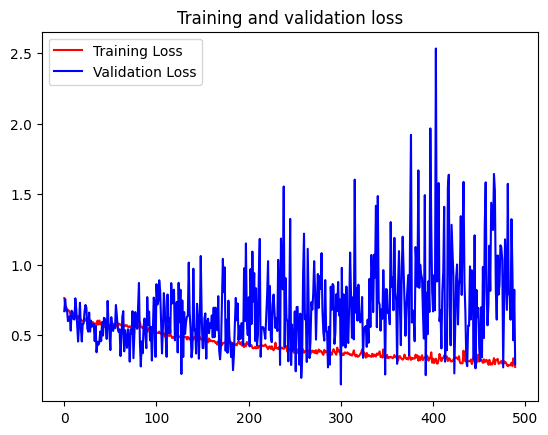

In [13]:
# Plot the chart for accuracy and loss on both training and validation

from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
import cv2

img_test = []

img_test.append(cv2.imread('dataset-sampah\plastic\plastic15.jpg'))

for i in range(len(img_test)):
    print(i)
    img_test[i] = cv2.resize(img_test[i], (150,150))/255

0


In [15]:
import numpy as np

img_test = np.asarray(img_test)

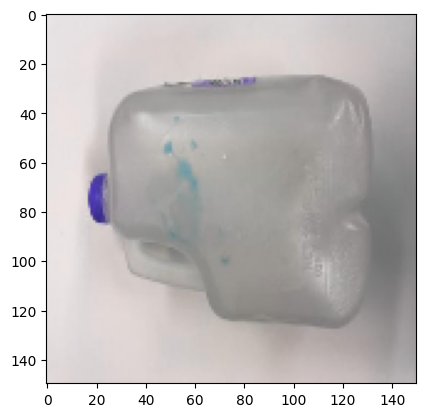

In [16]:
from matplotlib import pyplot as plt 

plt.imshow(img_test[0])

In [17]:
np.argmax(model.predict(img_test))

1/1 [==============================] - 0s 282ms/step


0